## Analyzing New York City employees' payroll database

### 🤔 Does tenure affect employees' overtime pay?

### Data Source: [NYC open data](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e/data)

#### The process ####
We started the project with some basic exploratory analyses into overtime pay for different city agencies. We were interested in practicing my newly acquired linear regression skills to see what factors could explain variance in overtime pay. That didn't lead to anything significant, so we did some more data wrangling and found some interesting patterns in overtime pay with some really strong outliers.

We then reported on the outliers and sought out experts from watchdog organizations who pointed that an employees' tenure might affect how much overtime they make. In this notebook, we'll show some of the strongest outliers in overtime earned and how much their tenure affects them.

#### Steps

1. Identify the agencies which we'll inspect more closely. Criteria for selecting agencies: The top three that spend the most in overtime, normalized for number of employees

2. Create a smaller dataframe with employees of just these three agencies and see what factors best explain number of overtime hours for each of these three agencies individually, and then all together.

3. Introduce tenure years to step 2 and see how much of a difference that makes.

4. Plot overtime earned against tenure.

#### Load the data and necessary Python package imports

In [1]:
import pandas as pd
from plotnine import *
import statsmodels.formula.api as smf

df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.lower()
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df.shape

(2864545, 17)

#### Cleaning the data

The database includes people whose work locations are outside of NYC. For this analyses, we're only including employees with work locations in NYC boroughs. Since Staten Island wasn't listed (unless included in the "other" location, this is filtered down to Queens, Manhattan, Bronx and Brooklyn.

In [3]:
boroughs = ['QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']

In [4]:
df = df[df.work_location_borough.isin(boroughs)]

In [5]:
df.shape

(2760682, 17)

Note: This reduces the dataset by 103,863 rows.

In [6]:
# Here's what the data looks like
df.head(3)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay
0,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARON,TERESA,NaN,03/21/2016,BRONX,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,825.00","51,709.59",588.00,"22,374.31",639.66
1,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARONS,CAMELIA,M,08/08/2016,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,595.55","41,960.18",121.75,"3,892.19",108.25
2,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL,MODUPE,NaN,02/11/2008,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","56,298.93",54.75,"2,455.88","3,938.75"


In [7]:
df.groupby(by='fiscal_year').total_ot_paid.sum().round()

fiscal_year
2017   1,866,990,981.00
2018   1,803,832,443.00
2019   1,781,905,103.00
2020   1,866,461,730.00
2021   1,695,474,497.00
Name: total_ot_paid, dtype: float64

#### 📝 Adding a column to calculate tenure.

In [8]:
df['agency_start_date'] = pd.to_datetime(df.agency_start_date, errors='coerce')
df['today'] = pd.to_datetime('today')
df['tenure_years'] = (df.today - df.agency_start_date).astype('timedelta64[Y]')

In [9]:
df.head(3)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
0,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARON,TERESA,NaN,2016-03-21,BRONX,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,825.00","51,709.59",588.00,"22,374.31",639.66,2022-05-16 23:44:51.061934,6.00
1,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARONS,CAMELIA,M,2016-08-08,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,595.55","41,960.18",121.75,"3,892.19",108.25,2022-05-16 23:44:51.061934,5.00
2,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL,MODUPE,NaN,2008-02-11,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","56,298.93",54.75,"2,455.88","3,938.75",2022-05-16 23:44:51.061934,14.00


#### 📝 Which agencies spend the most on overtime?

In [10]:
df.groupby(by='agency_name').total_ot_paid.sum().reset_index().sort_values(by='total_ot_paid', ascending = False).head(5)

,agency_name,total_ot_paid
125,POLICE DEPARTMENT,"3,410,660,240.39"
88,FIRE DEPARTMENT,"1,596,842,055.03"
59,DEPARTMENT OF CORRECTION,"981,672,183.09"
65,DEPARTMENT OF SANITATION,"790,873,824.62"
114,NYC HOUSING AUTHORITY,"553,297,085.88"


### Creating a new dataframe for just these three agencies

In [11]:
three_agencies = ['POLICE DEPARTMENT', 'FIRE DEPARTMENT', 'DEPARTMENT OF CORRECTION']

In [12]:
df_agencies = df[df.agency_name.isin(three_agencies)]

In [13]:
df_agencies.head(3)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
91106,2017,NaN,DEPARTMENT OF CORRECTION,AARON,SHELLON,NaN,2010-12-16,QUEENS,CORRECTION OFFICER,ACTIVE,"82,808.00",per Annum,"1,970.02","78,954.24",599.52,"43,311.50","14,064.12",2022-05-16 23:44:51.061934,11.00
91107,2017,NaN,DEPARTMENT OF CORRECTION,AAYAN,IBRAHIM,NaN,2016-06-27,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,"2,085.72","42,209.08",411.75,"12,887.34","2,951.43",2022-05-16 23:44:51.061934,5.00
91108,2017,NaN,DEPARTMENT OF CORRECTION,ABASI,JUSTIN,NaN,2017-06-19,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,74.28,825.46,0.00,0.00,0.00,2022-05-16 23:44:51.061934,4.00


/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 16346 rows containing missing values.


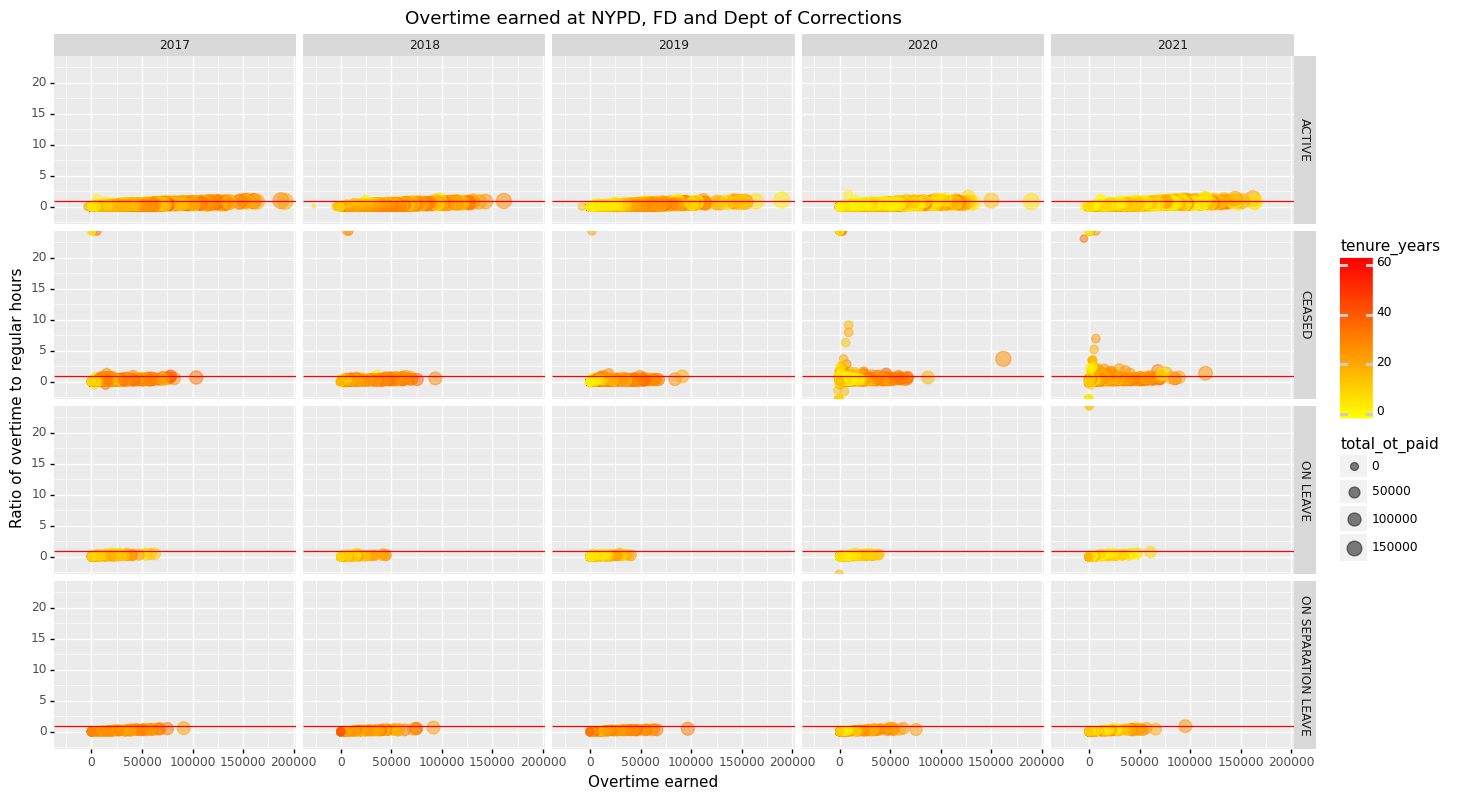

<ggplot: (375616245)>

In [14]:
(
    ggplot(df_agencies, 
           aes(x='total_ot_paid', y='ot_hours/regular_hours', color='tenure_years', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('leave_status_as_of_june_30~fiscal_year') +
        scale_color_gradient(low='yellow',high='red') + 
        labs(
            title = 'Overtime earned at NYPD, FD and Dept of Corrections',
            y = 'Ratio of overtime to regular hours',
            x = 'Overtime earned'
        ) + 
        theme(figure_size=(16,9))

)    

## 🎯 Throughout the dataset, employees who clocked in the most overtime hours versus regualr hours are no longer on the payroll. Let's zoom into them.

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 15731 rows containing missing values.


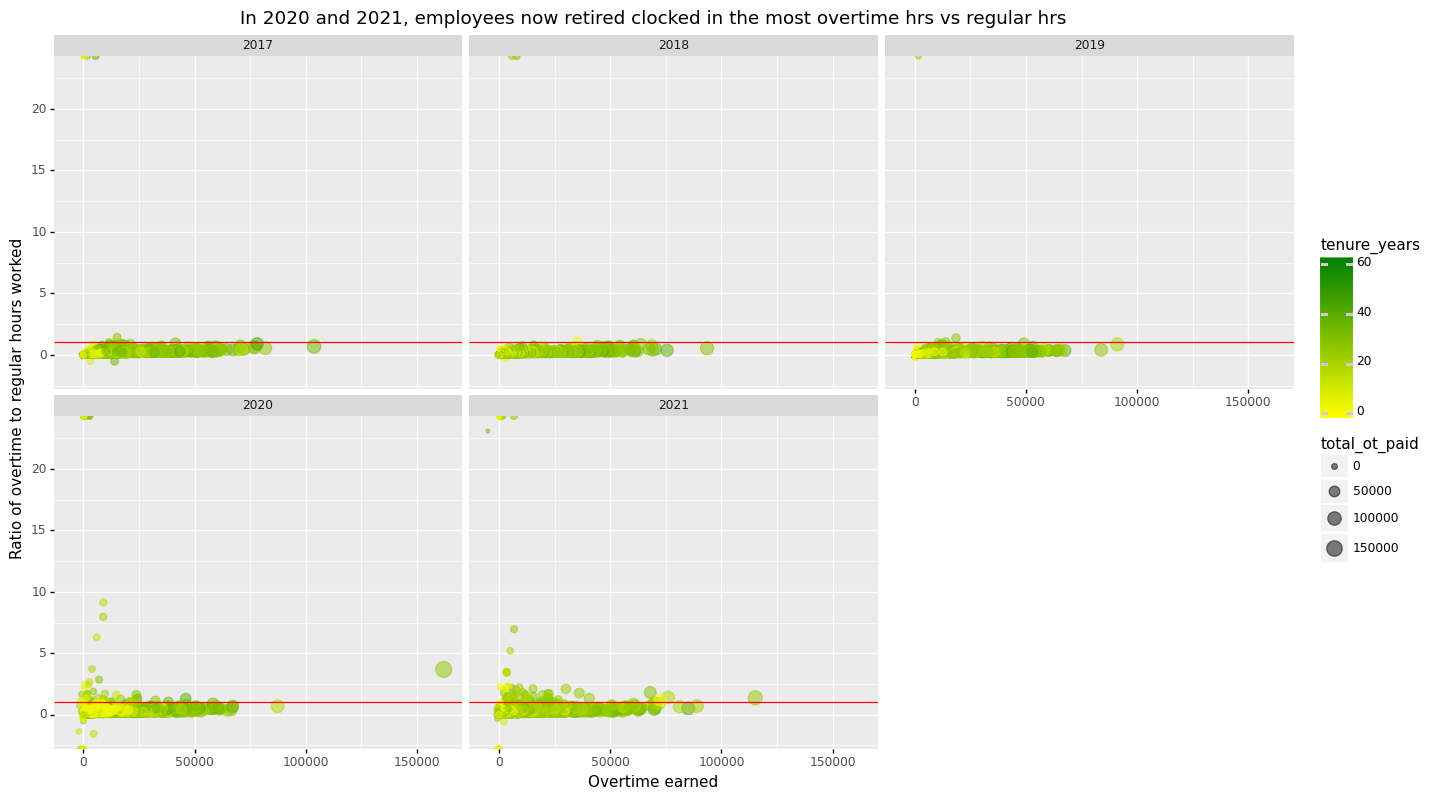

<ggplot: (383730010)>

In [15]:
(
    ggplot(df_agencies.query('leave_status_as_of_june_30 == "CEASED"'), 
           aes(x='total_ot_paid', y='ot_hours/regular_hours', color='tenure_years', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_wrap('fiscal_year') +
        scale_color_gradient(low='yellow',high='green') + 
        labs(
            title = "In 2020 and 2021, employees now retired clocked in the most overtime hrs vs regular hrs",
            y = "Ratio of overtime to regular hours worked",
            x = "Overtime earned"
        ) +
        theme(figure_size=(16,9))

)    

### Who are these employees who are:
1. Now retired
2. Worked more overtime than regular hours?

In [16]:
df_agencies.query('ot_hours/regular_hours > 1').query('leave_status_as_of_june_30 == "CEASED"').query('regular_hours > 0')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
442668,2017,NaN,FIRE DEPARTMENT,HOPKINS,MICHAEL,W,1994-02-28,BROOKLYN,FIREFIGHTER,CEASED,"82,808.00",per Annum,80.02,"24,791.08",114.00,"15,189.39","-8,330.92",2022-05-16 23:44:51.061934,28.00
525847,2017,NaN,POLICE DEPARTMENT,HUNTER-CLARK,TOBIA,M,1996-07-18,MANHATTAN,SERGEANTD/A SUPERVISOR DETECTIVE SQUAD,CEASED,"118,902.00",per Annum,102.87,"35,647.26",104.00,"11,448.78","4,849.41",2022-05-16 23:44:51.061934,25.00
615946,2018,72.00,DEPARTMENT OF CORRECTION,COBBINAH,FELIX,NaN,2017-05-30,BRONX,MARINE ENGINEER,CEASED,36.19,per Hour,519.12,"21,105.89",543.25,"35,201.16",903.68,2022-05-16 23:44:51.061934,4.00
1649536,2019,56.00,POLICE DEPARTMENT,GARGAN,MICHAEL,P,1994-02-28,MANHATTAN,SERGEANT-,CEASED,"109,360.00",per Annum,148.57,"36,779.78",202.22,"18,547.98","4,335.75",2022-05-16 23:44:51.061934,28.00
1667721,2019,56.00,POLICE DEPARTMENT,OBRIEN,MICHAEL,D,1995-06-30,MANHATTAN,POLICE OFFICER D/A DETECTIVE 2ND GR,CEASED,"106,175.00",per Annum,148.57,"83,557.56",160.00,"13,980.13","4,277.34",2022-05-16 23:44:51.061934,26.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648418,2021,57.00,FIRE DEPARTMENT,ABBOTT,MICHAEL,W,2007-08-06,BROOKLYN,FIREFIGHTER,CEASED,"85,292.00",per Annum,22.87,932.20,78.00,"3,289.30","10,911.86",2022-05-16 23:44:51.061934,14.00
2655614,2021,57.00,FIRE DEPARTMENT,DELGADO,RICHARD,L,2008-07-31,BROOKLYN,FIREFIGHTER,CEASED,"85,292.00",per Annum,22.87,932.20,48.00,"2,636.45","8,749.76",2022-05-16 23:44:51.061934,13.00
2690092,2021,57.00,FIRE DEPARTMENT,SOKOLOW,SHALOM,NaN,2019-07-01,BROOKLYN,ATTENDING PHYSICIAN,CEASED,58.79,per Hour,21.00,"2,061.55",50.00,"3,987.09",-951.98,2022-05-16 23:44:51.061934,2.00
2697521,2021,57.00,FIRE DEPARTMENT,GUSZACK,CHRISTOPHER,B,2019-07-01,BROOKLYN,ATTENDING PHYSICIAN,CEASED,58.79,per Hour,13.00,"3,339.59",28.00,"2,934.17","-2,017.78",2022-05-16 23:44:51.061934,2.00


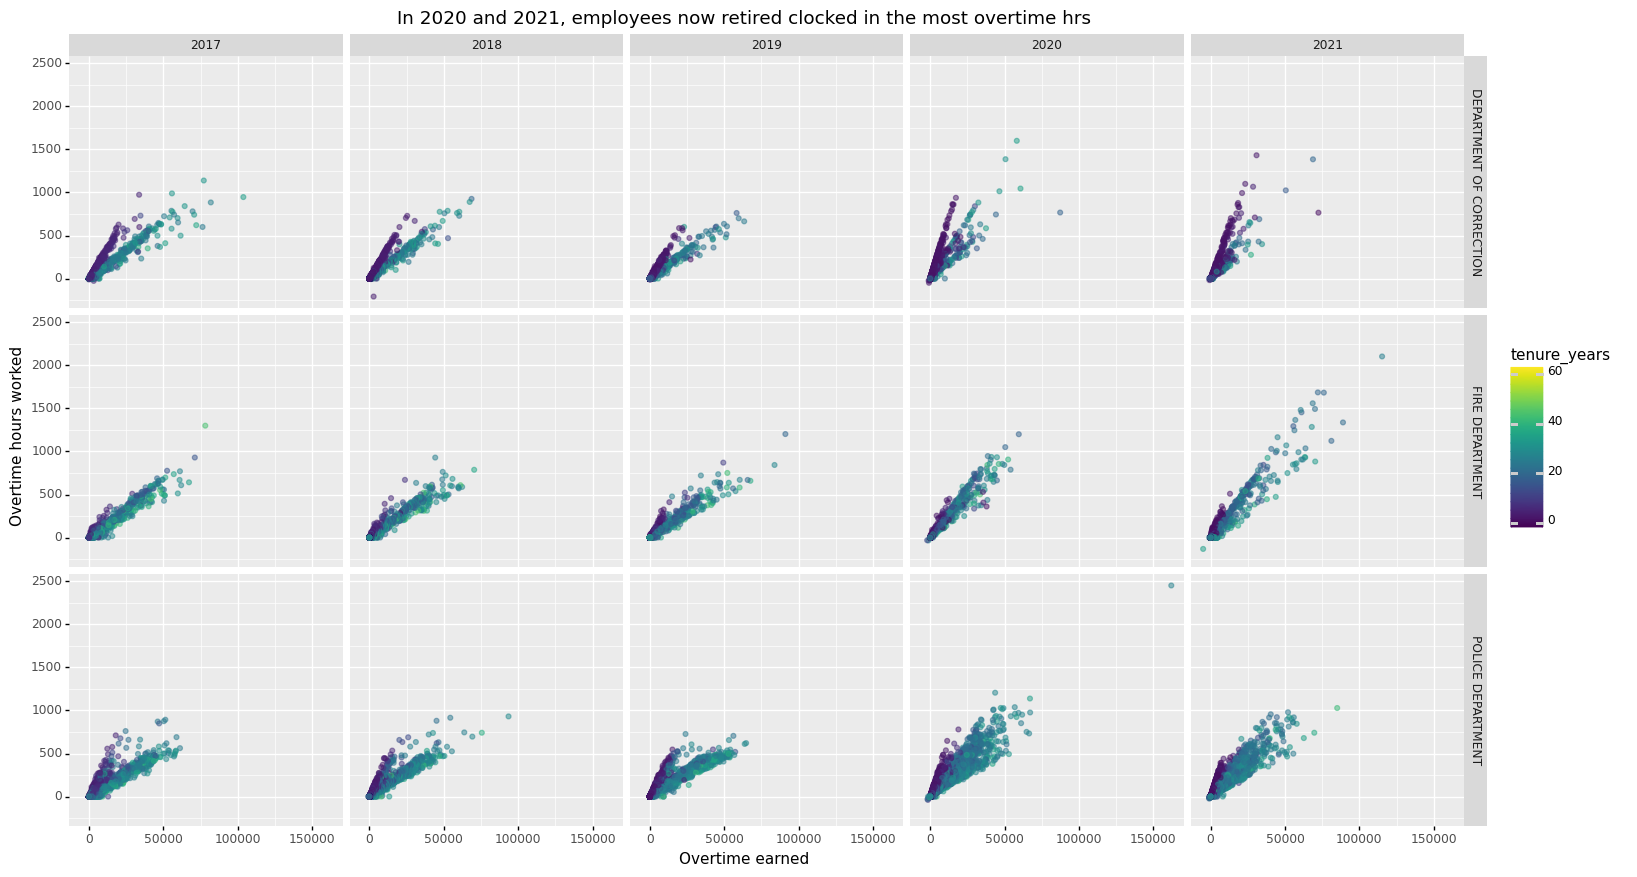

<ggplot: (377075550)>

In [17]:
(
    ggplot(df_agencies.query('leave_status_as_of_june_30 == "CEASED"'), 
           aes(x='total_ot_paid', y='ot_hours', color='tenure_years')) +
        geom_point(alpha=.5) +
        facet_grid('agency_name~fiscal_year') +
        labs(
            title = "In 2020 and 2021, employees now retired clocked in the most overtime hrs",
            y = "Overtime hours worked",
            x = "Overtime earned"
        ) +
        theme(figure_size=(18,10))

)    

### 🎯 2020 and 2021 showed the highest range of overtime hours worked with some employees clocking over 1000 hours. Most of these employees are in the 20-40 year tenure bracket.


### With this in mind, let's look at how tenure impacts overtime for all enmployees across all agencies. Here we'll plot the ratio of overtime hours and regular hours worked against their tenure.

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


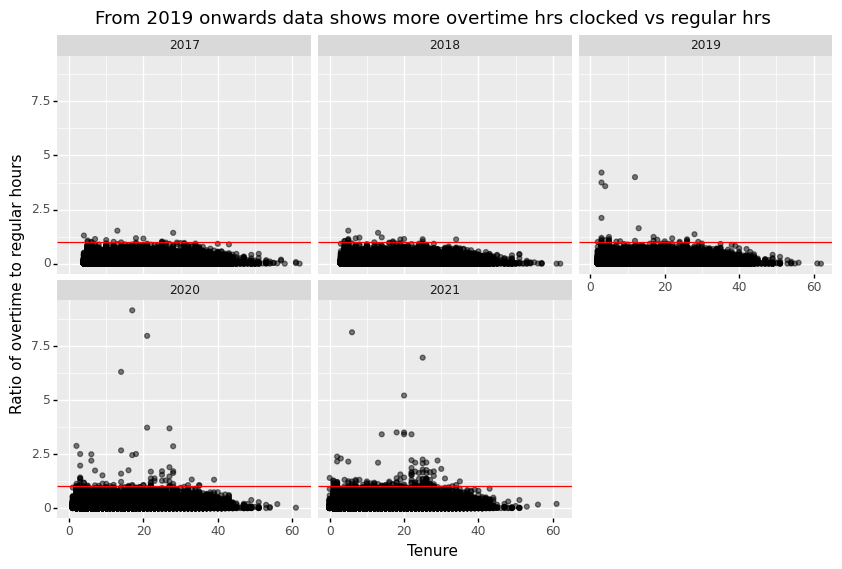

<ggplot: (365842577)>

In [18]:
(
    ggplot(df.query('regular_hours > 0').query('ot_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.5) +
        facet_wrap('fiscal_year') +
        geom_hline(aes(yintercept=1), color='red') + 
#         geom_vline(aes(xintercept=1), color='yellow') +
        labs(
            title = "From 2019 onwards data shows more overtime hrs clocked vs regular hrs",
            y = "Ratio of overtime to regular hours",
            x = "Tenure"
        ) +
        theme(figure_size=(10,6))

)    

### The phenomenon especially began to emerge from 2019 onwards. Now let's plot just retired employees by borough

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


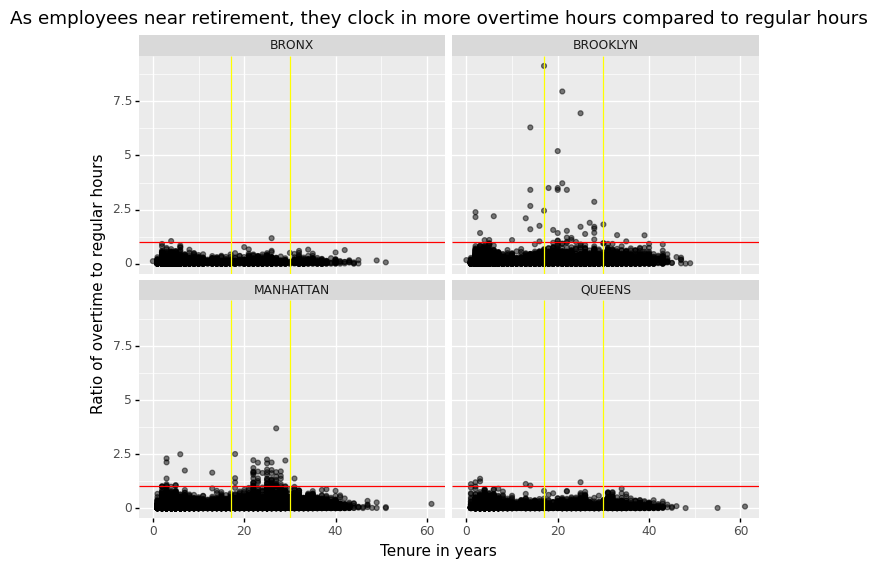

<ggplot: (383768991)>

In [19]:
(
    ggplot(df.query('regular_hours > 0').query('ot_hours > 0').query('leave_status_as_of_june_30 == "CEASED"'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') +
        geom_vline(aes(xintercept=17), color='yellow') +
        geom_vline(aes(xintercept=30), color='yellow') +
        facet_wrap('work_location_borough') +
        labs(
            title = "As employees near retirement, they clock in more overtime hours compared to regular hours",
            y = "Ratio of overtime to regular hours",
            x = "Tenure in years"
        ) +
        theme(figure_size=(8,6))

)    

In [20]:
df.query('first_name == "KEVIN"').query('last_name == "MURTHA"').query('agency_start_date == "1995-04-30"').total_ot_paid.sum()

332554.82

In [21]:
df.query('first_name == "KEVIN"').query('last_name == "MURTHA"').query('agency_start_date == "1995-04-30"')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
539518,2017,NaN,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,1995-04-30,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"134,067.00",per Annum,"2,051.43","132,640.94",433.70,"50,799.80","28,006.50",2022-05-16 23:44:51.061934,27.00
1082287,2018,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,1995-04-30,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"138,089.00",per Annum,"2,045.72","134,294.80",536.33,"62,473.98","27,815.30",2022-05-16 23:44:51.061934,27.00
1697037,2019,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,1995-04-30,BROOKLYN,LIEUTENANT D/A SPECIAL ASSIGNMENT,ACTIVE,"138,089.00",per Annum,"2,040.00","137,710.56",387.87,"57,280.57","25,084.00",2022-05-16 23:44:51.061934,27.00
1705627,2020,56.00,POLICE DEPARTMENT,MURTHA,KEVIN,NaN,1995-04-30,MANHATTAN,LIEUTENANT D/A SPECIAL ASSIGNMENT,CEASED,"141,196.00",per Annum,665.18,"48,008.86","2,451.57","162,000.47","78,132.88",2022-05-16 23:44:51.061934,27.00


/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


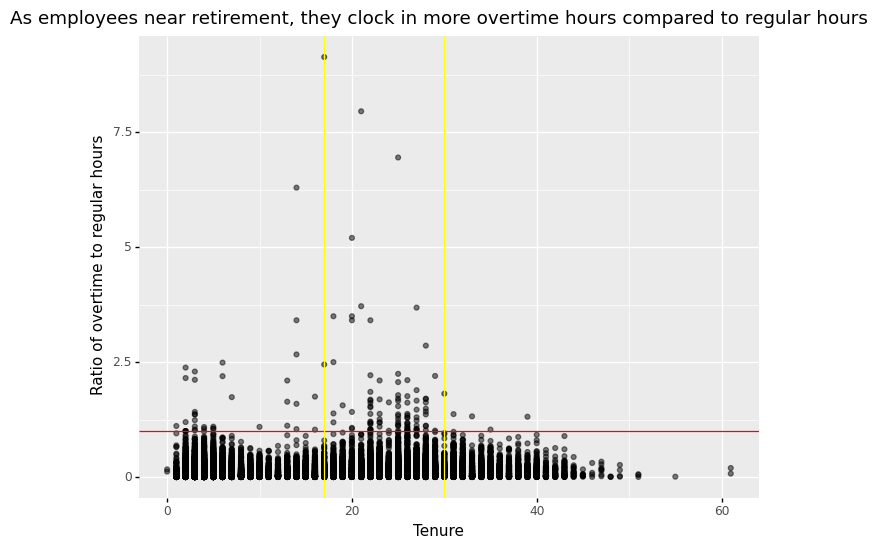

<ggplot: (377971280)>

In [22]:
(
    ggplot(df.query('regular_hours > 0').query('ot_hours > 0').query('leave_status_as_of_june_30 == "CEASED"'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') +
        geom_vline(aes(xintercept=17), color='yellow') +
        geom_vline(aes(xintercept=30), color='yellow') +
        labs(
            title = "As employees near retirement, they clock in more overtime hours compared to regular hours",
            y = "Ratio of overtime to regular hours",
            x = "Tenure"
        ) +
        theme(figure_size=(8,6))

)    

In [23]:
model = smf.ols('ot_hours ~ regular_hours + work_location_borough + agency_name', data=df_agencies) 
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                 2.207e+04
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        23:45:44   Log-Likelihood:            -3.0445e+06
No. Observations:              448809   AIC:                         6.089e+06
Df Residuals:                  448802   BIC:                         6.089e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            -47.9774      1.674    -28.653      0.000     -51.259     -44.696
work_location_borough[T.BROOKLYN]     -3.7545      1.117     -3.362      0.001      -5.943      -1.566
work_location_borough[T.MANHATTAN]    43.2550      1.077     40.144      0.000      41.143      45.367
work_location_borough[T.QUEENS]        3.6591      1.127      3.248      0.001       1.451       5.867
agency_name[T.FIRE DEPARTMENT]        39.9721      1.188     33.658      0.000      37.644      42.300
agency_name[T.POLICE DEPARTMENT]     -76.8922      1.034    -74.339      0.000     -78.919     -74.865
regular_hours                          0.1805      0.001    324.954      0.000       0.179       0.182
==============================================================================
Omnibus:                    96872.599   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260718.977
Skew:                           1.161   Prob(JB):                         0.00
Kurtosis:                       5.923   Cond. No.                     1.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
model = smf.ols('ot_hours ~ base_salary + agency_name + tenure_years', data=df_agencies) 
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     9748.
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        23:45:45   Log-Likelihood:            -3.0838e+06
No. Observations:              448809   AIC:                         6.168e+06
Df Residuals:                  448804   BIC:                         6.168e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          179.8182      1.169    153.868      0.000     177.528     182.109
agency_name[T.FIRE DEPARTMENT]      56.8350      1.197     47.480      0.000      54.489      59.181
agency_name[T.POLICE DEPARTMENT]   -65.5915      1.002    -65.484      0.000     -67.555     -63.628
base_salary                          0.0014   1.24e-05    113.509      0.000       0.001       0.001
tenure_years                        -0.0177      0.046     -0.382      0.703      -0.109       0.073
==============================================================================
Omnibus:                    85658.007   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186181.813
Skew:                           1.114   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                     3.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""